# The Pacific Northwest

In [74]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import librosa
import os

from IPython.display import Audio

IMAGE_PATH = 'images/'
SOUND_PATH = 'sounds/'

### 1.1 Correlation in Signals

In [75]:
flicker, flicker_sr = librosa.load(SOUND_PATH + 'flicker.mp3')

display(Audio(flicker, rate=flicker_sr))

https://www.youtube.com/watch?v=YQ2wIOcO7aE&ab_channel=AppleseedOutdoors

In [76]:
def calculate_sound_autocorrelation(y, sr, max_lag):
    # Calculate autocorrelation using numpy
    autocorr = np.correlate(y, y, mode='full')
    autocorr = autocorr[autocorr.size // 2:]  # Keep only the second half
    
    # Normalize the autocorrelation
    autocorr /= autocorr.max()

    # Consider only lags up to max_lag
    lags = np.arange(0, max_lag)
    autocorr = autocorr[:max_lag]

    return lags, autocorr

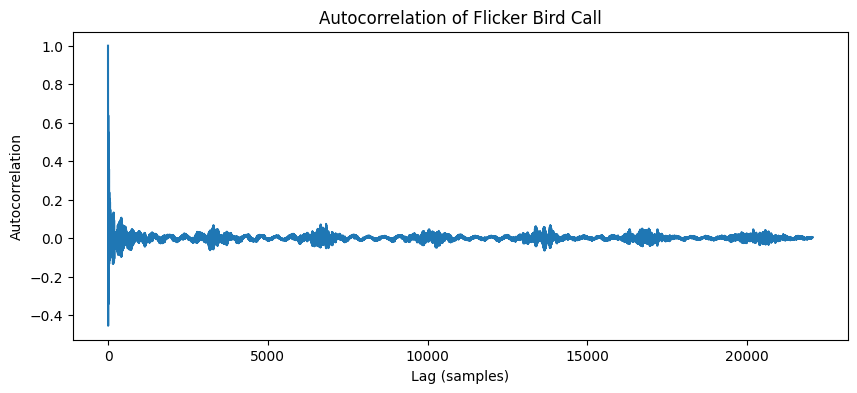

In [77]:
lags, autocorr = calculate_sound_autocorrelation(flicker, flicker_sr, flicker_sr)

plt.figure(figsize=(10, 4))
plt.plot(lags, autocorr)
plt.xlabel('Lag (samples)')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation of Flicker Bird Call')
plt.show()

#### Measuring periodicity numerically

In [78]:
from scipy.signal import find_peaks

peak_samples, peak_correlations = find_peaks(autocorr, height=0.03, distance=1000)

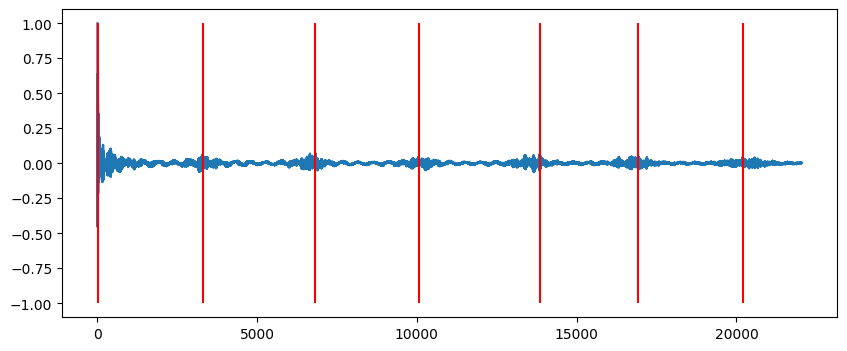

In [79]:
# plot autocorrelation with samples marked
plt.figure(figsize=(10, 4))
plt.plot(lags, autocorr)

# mark the samples with red bars
plt.vlines(peak_samples, -1, 1, color='r')

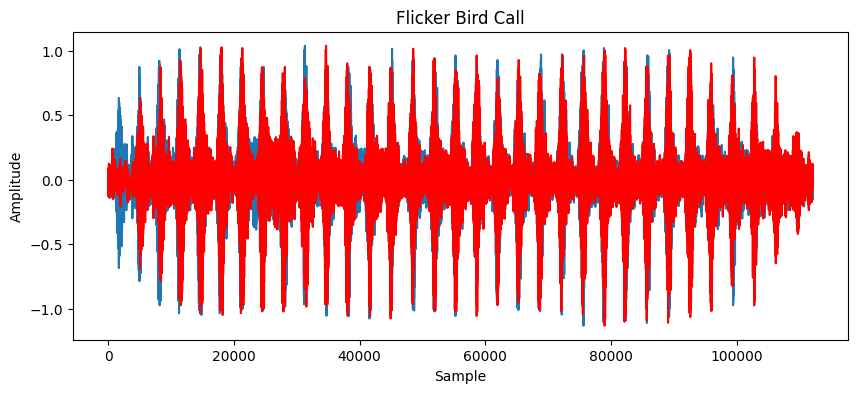

In [80]:
# average difference between peaks
avg_peak_diff = np.diff(peak_samples).mean()
flicker_shifted = np.roll(flicker, int(avg_peak_diff))

# plot the original signal
plt.figure(figsize=(10, 4))
plt.plot(flicker)
plt.plot(flicker_shifted, color='r')
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.title('Flicker Bird Call')
plt.show()

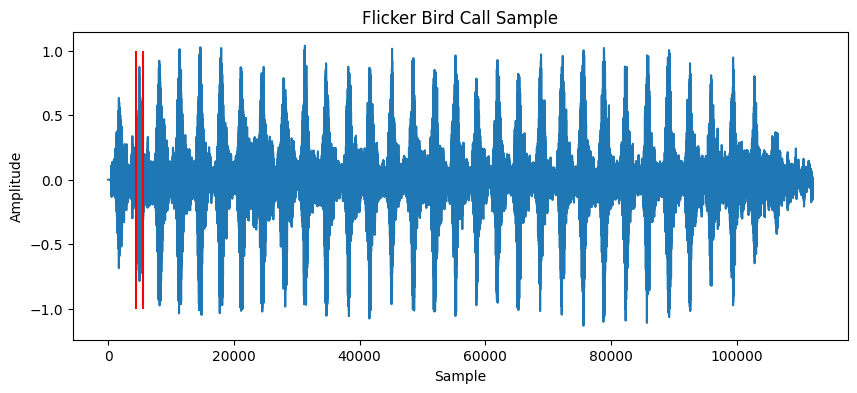

In [81]:
sample_window = (4500, 5500)
flicker_sample = flicker[sample_window[0]:sample_window[1]]

# plot the sample
plt.figure(figsize=(10, 4))
plt.plot(flicker)
plt.vlines(sample_window, -1, 1, color='r')
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.title('Flicker Bird Call Sample')
plt.show()

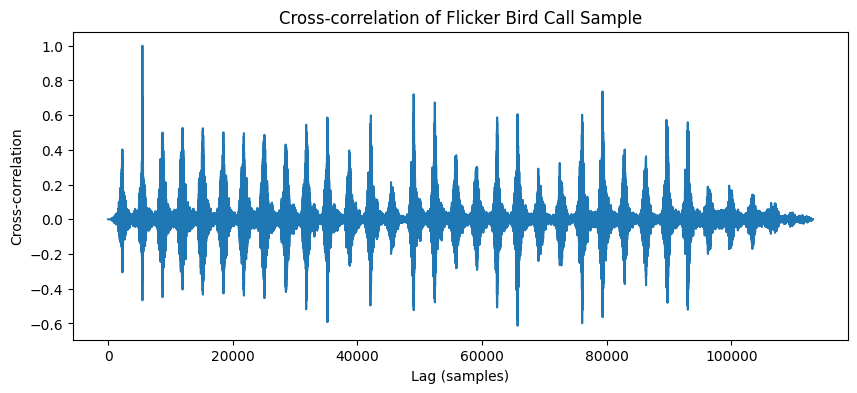

In [82]:
# find the flicker_sample in the flciker signal with cross-correlation
cross_corr = np.correlate(flicker, flicker_sample, mode='full')
#cross_corr = cross_corr[cross_corr.size // 2:]  # Keep only the second half

# normalize the cross-correlation
cross_corr /= cross_corr.max()

# plot the cross-correlation
plt.figure(figsize=(10, 4))
plt.plot(cross_corr)
plt.xlabel('Lag (samples)')
plt.ylabel('Cross-correlation')
plt.title('Cross-correlation of Flicker Bird Call Sample')
plt.show()


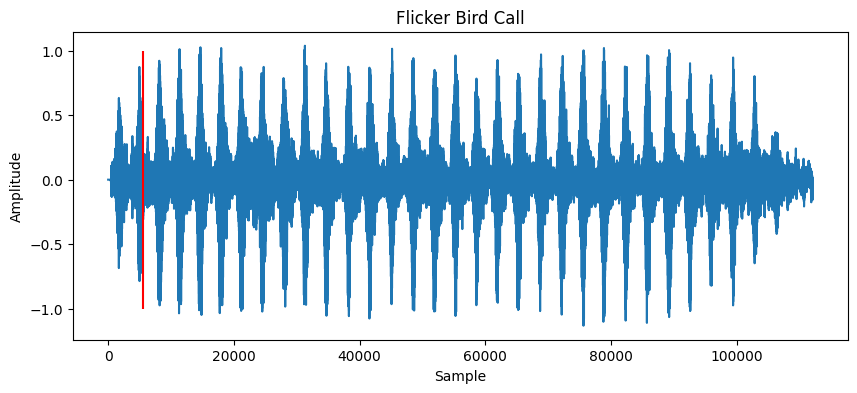

In [83]:
sample_position = cross_corr.argmax()

# plot the flicker signal and mark the sample_position with a vline
plt.figure(figsize=(10, 4))
plt.plot(flicker)
plt.vlines(sample_position, -1, 1, color='r')
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.title('Flicker Bird Call')
plt.show()

### 1.2 Segmentation, morphological operations, object attributes in images

Segmentation Techniques:
- Threshold-based segmentation
- Edge-based image segmentation
- Region-based image segmentation
- Clustering-based image segmentation
- Artificial neural network-based segmentation

Counter({0: 136915, 3: 4855, 2: 3639, 5: 1836, 4: 1352, 6: 104, 1: 49})
There are 5 separate objects in the image.


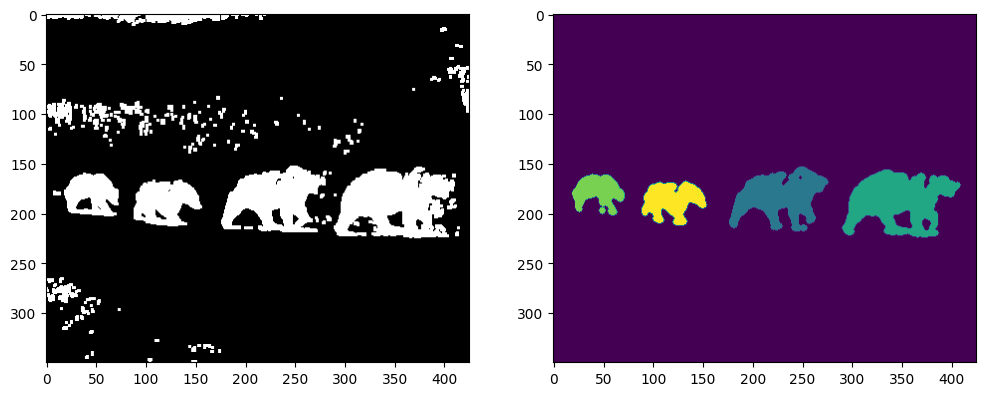

In [84]:
from skimage.filters import threshold_otsu
from skimage.morphology import closing, square
from skimage.segmentation import clear_border

#import the disk structuring element from skimage.morphology
from skimage.morphology import disk

img = cv2.imread(IMAGE_PATH + 'bears.jpg', cv2.IMREAD_GRAYSCALE)

# Instead of equalizing the histogram, we will use CLAHE
clahe = cv2.createCLAHE(clipLimit=1.0, tileGridSize=(3,3))
clahe = clahe.apply(img)
img_cont_clahe = cv2.addWeighted(clahe, 1.5, np.zeros(img.shape, img.dtype), 0, 0)

# otsu thresholding
thresh = threshold_otsu(img_cont_clahe)
bw = closing(img_cont_clahe > thresh, square(3))

# invert the image
bw = np.logical_not(bw)

# remove artifacts connected to image border
cleared = clear_border(bw)
# apply opening
cleared = np.array(cleared, dtype=np.uint8)
cleared = cv2.morphologyEx(cleared, cv2.MORPH_OPEN, disk(3))

# remove small fragments
cleared = np.array(cleared, dtype=np.uint8)
cleared = cv2.erode(cleared, disk(3))

# remove thin lines
cleared = np.array(cleared, dtype=np.uint8)
cleared = cv2.dilate(cleared, disk(2))

# remove artifacts
cleared = np.array(cleared, dtype=np.uint8)
cleared = cv2.morphologyEx(cleared, cv2.MORPH_OPEN, disk(3))

# label image regions
from skimage.measure import label
label_image = label(cleared)

# list sizes of labeled areas
from collections import Counter
print(Counter(label_image.flatten()))

# remove small labels
from skimage.morphology import remove_small_objects
label_image = remove_small_objects(label_image, min_size=200)

print('There are {} separate objects in the image.'.format(label_image.max()))

# plot the images
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(bw, cmap='gray')
ax[1].imshow(label_image)
plt.show()

### 2.1 Keypoint Matching

#### Resizing images
The Histogram of Oriented Gradients (HOG) algorithm in later steps requires to divide images that should be keypoint-matched into bins. To implement this approach in the most straightforward way, I resize the images into a square `256*256` image.

In [85]:
import numpy as np
import matplotlib.pyplot as plt
import cv2  # Make sure to have OpenCV installed for cv2.resize

def resize_and_crop(image, size, offset_x=0, offset_y=0, zoom=1):
    """
    Resize the input image to a square of size 'size' by cropping and zooming.

    Parameters:
    image (numpy.ndarray): The input image to crop.
    size (int): The desired width and height of the squared image.
    offset_x (int): The horizontal center offset for cropping. Default is 0.
    offset_y (int): The vertical center offset for cropping. Default is 0.
    zoom (float): The zoom factor. Values > 1 will zoom in, < 1 will zoom out.

    Returns:
    numpy.ndarray: The cropped and zoomed image.
    """
    # Adjust the size based on the zoom factor
    zoomed_size = int(size / zoom)

    # Ensure the offsets are within the image dimensions
    height, width = image.shape[:2]
    center_x = min(max(offset_x, zoomed_size // 2), width - zoomed_size // 2)
    center_y = min(max(offset_y, zoomed_size // 2), height - zoomed_size // 2)

    # Calculate the cropping area, centered around (offset_x, offset_y)
    start_x = center_x - zoomed_size // 2
    end_x = center_x + zoomed_size // 2
    start_y = center_y - zoomed_size // 2
    end_y = center_y + zoomed_size // 2

    # Crop the image
    cropped_image = image[start_y:end_y, start_x:end_x]

    # If zooming in, resize back to the original size parameter
    if zoom != 1:
        cropped_image = cv2.resize(cropped_image, (size, size))

    # Plotting the original and cropped images
    plt.figure(figsize=(12, 6))

    # Original Image with Crop Square
    plt.subplot(1, 2, 1)
    plt.title('Original Image with Crop Area')
    plt.imshow(image)
    # Draw a rectangle on the original image to represent the crop area
    plt.gca().add_patch(plt.Rectangle((start_x, start_y), zoomed_size, zoomed_size,
                                      edgecolor='red', facecolor='none', lw=2))
    plt.axis('off')

    # Cropped & Zoomed Image
    plt.subplot(1, 2, 2)
    plt.title('Cropped & Zoomed Image')
    plt.imshow(cropped_image)
    plt.axis('off')

    plt.show()

    return cropped_image


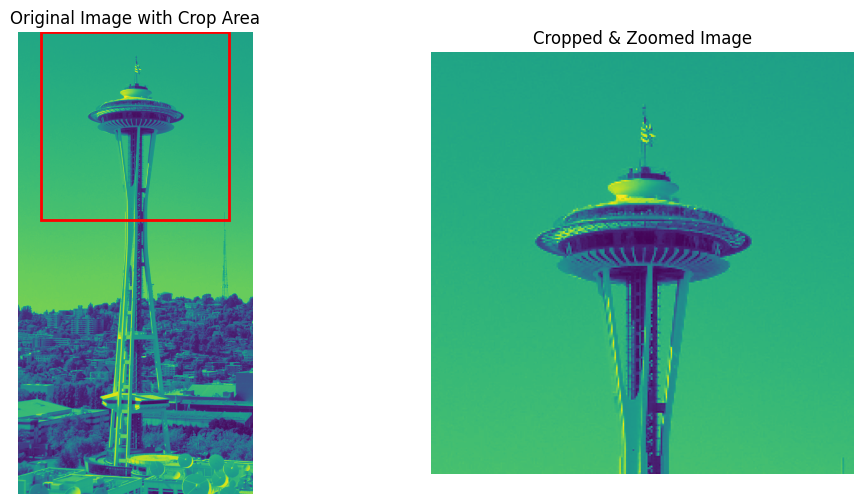

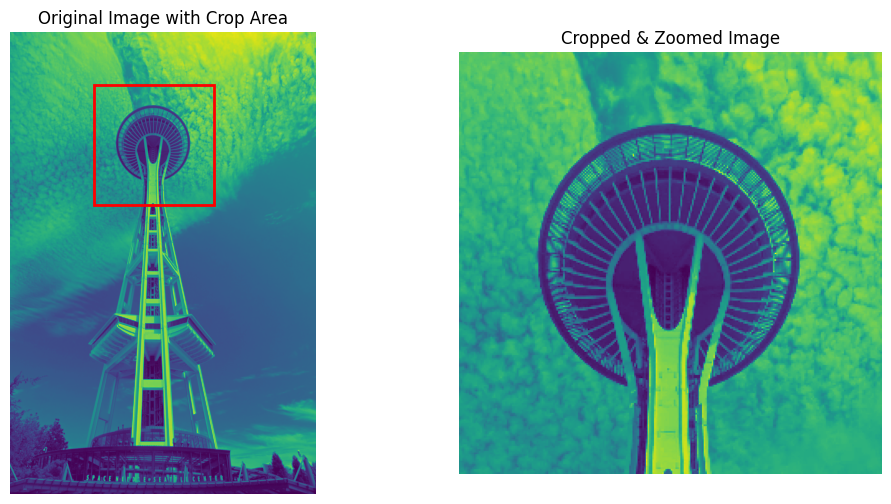

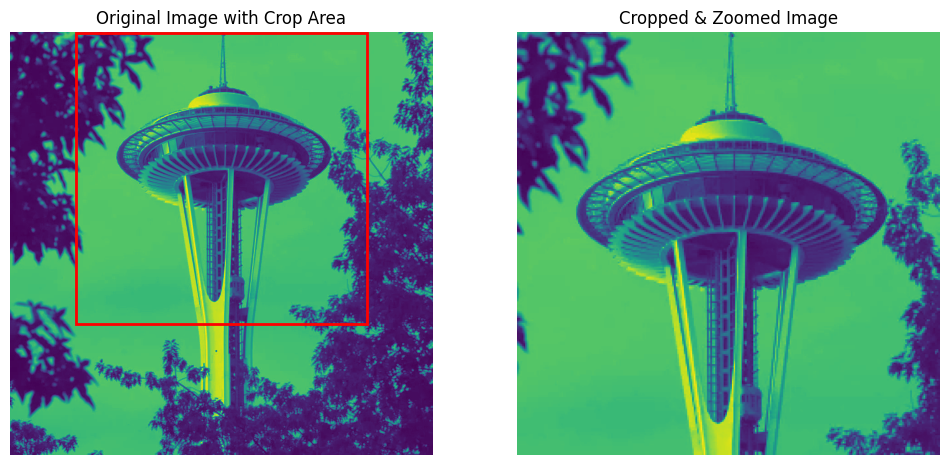

In [86]:
image1 = cv2.imread(IMAGE_PATH + 'keypoint_matching/1.jpeg', cv2.IMREAD_GRAYSCALE)
image1 = resize_and_crop(image1, 256, offset_x=image1.shape[1]//2, offset_y=0, zoom=0.4)

image2 = cv2.imread(IMAGE_PATH + 'keypoint_matching/2.jpeg', cv2.IMREAD_GRAYSCALE)
image2 = resize_and_crop(image2, 256, offset_x=image2.shape[1]//2-100, offset_y=1200, zoom=0.2)

image3 = cv2.imread(IMAGE_PATH + 'keypoint_matching/3.jpeg', cv2.IMREAD_GRAYSCALE)
image3 = resize_and_crop(image3, 256, offset_x=image3.shape[1]//2, offset_y=0, zoom=0.4)


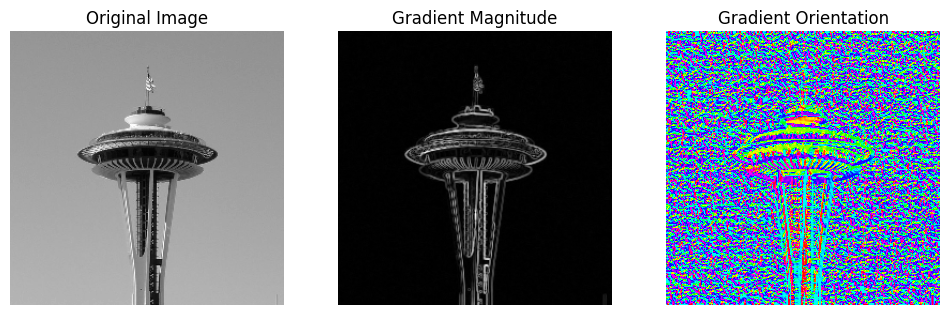

In [87]:
def calculate_gradient_of_image(image, kernel_size=3):
    dx = cv2.Sobel(image, cv2.CV_32F, 1, 0, ksize=kernel_size)
    dy = cv2.Sobel(image, cv2.CV_32F, 0, 1, ksize=kernel_size)
    
    return dx, dy

def calculate_magnitude(dx, dy):
    magnitude = np.sqrt(dx**2 + dy**2)
    
    return magnitude

def calculate_orientation(dx, dy):
    angle = np.arctan2(dy, dx)
    
    return angle

dx, dy = calculate_gradient_of_image(image1)
magnitude = calculate_magnitude(dx, dy)
orientation = calculate_orientation(dx, dy)

def show_hog_steps(image):
    dx, dy = calculate_gradient_of_image(image)
    magnitude = calculate_magnitude(dx, dy)
    orientation = calculate_orientation(dx, dy)
    
    fig, ax = plt.subplots(1, 3, figsize=(12, 6))
    ax[0].imshow(image, cmap='gray')
    ax[0].set_title('Original Image')
    ax[0].axis('off')
    ax[1].imshow(magnitude, cmap='gray')
    ax[1].set_title('Gradient Magnitude')
    ax[1].axis('off')
    ax[2].imshow(orientation, cmap='hsv')
    ax[2].set_title('Gradient Orientation')
    ax[2].axis('off')
    plt.show()
    
show_hog_steps(image1)


In [108]:
def calculate_histograms(magnitude, angle, cell_size=(4, 4), num_bins=9):
    # Initialize the bins for the histogram
    bins_range = np.linspace(-np.pi, np.pi, num_bins+1)
    
    # Determine the size of the image
    height, width = magnitude.shape
    
    # Calculate the number of cells along the width and height
    cells_x = width // cell_size[0]
    cells_y = height // cell_size[1]
    
    # Initialize the histogram of gradients
    hog = np.zeros((cells_y, cells_x, num_bins))
    
    # Loop over each cell
    for cx in range(cells_x):
        for cy in range(cells_y):
            # Find the boundaries of the cell
            x_start = cx * cell_size[0]
            x_end = x_start + cell_size[0]
            y_start = cy * cell_size[1]
            y_end = y_start + cell_size[1]
            
            # Extract the cell's magnitude and angle
            cell_magnitude = magnitude[y_start:y_end, x_start:x_end]
            cell_angle = angle[y_start:y_end, x_start:x_end]
            
            # Calculate the histogram for the cell
            cell_hist, _ = np.histogram(cell_angle, bins=bins_range, weights=cell_magnitude)
            
            # Store the histogram in the hog descriptor
            hog[cy, cx, :] = cell_hist
    
    # normalize the histogram
    hog /= hog.max()
    
    return hog

def plot_hog(hog, cell_size=(4, 4), num_bins=9):
    # Calculate the size of the image
    img_height, img_width = hog.shape[0] * cell_size[0], hog.shape[1] * cell_size[1]
    plt.figure(figsize=(8,8))
    plt.xlim([0, img_width])
    plt.ylim([0, img_height])
    plt.gca().invert_yaxis()
    
    # Bin centers based on number of bins
    bin_centers = np.linspace(0, 2 * np.pi, num_bins, endpoint=False)
    
    # Plotting the HOG cells
    for y in range(hog.shape[0]):
        for x in range(hog.shape[1]):
            cell_magnitude = hog[y, x, :]
            cell_max_mag = np.amax(cell_magnitude)
            if cell_max_mag > 0:
                cell_magnitude = cell_magnitude / cell_max_mag  # Normalize the magnitudes for visualization purposes
            for o in range(num_bins):
                angle = bin_centers[o]
                magnitude = cell_magnitude[o]
                dx = magnitude * cell_size[0] * np.cos(angle) / 2.0
                dy = magnitude * cell_size[1] * np.sin(angle) / 2.0
                x1 = (x + 0.5) * cell_size[0] - dx
                y1 = (y + 0.5) * cell_size[1] - dy
                x2 = (x + 0.5) * cell_size[0] + dx
                y2 = (y + 0.5) * cell_size[1] + dy
                plt.plot([x1, x2], [y1, y2], 'r', linewidth=1, alpha=0.6)

    plt.title("HOG Feature Descriptors")
    plt.axis('off')
    plt.show()

hog = calculate_histograms(magnitude, orientation)

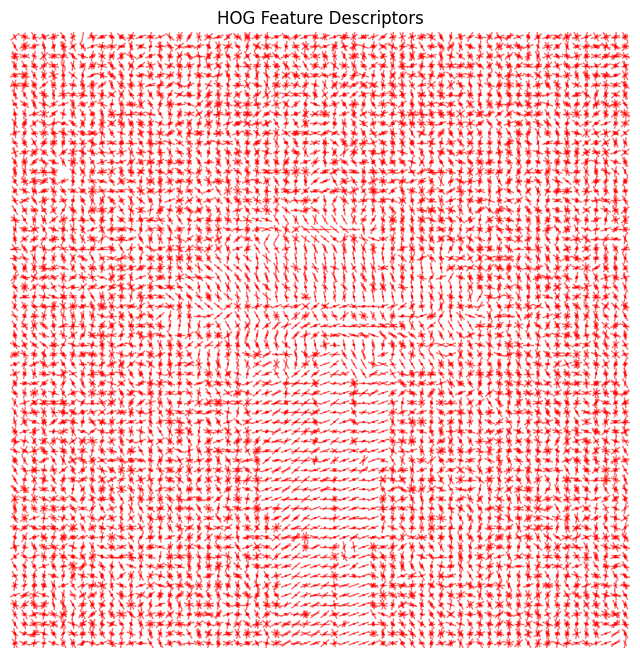

In [109]:
# plot hog
plot_hog(hog)

In [114]:
magnitude1 = calculate_magnitude(*calculate_gradient_of_image(image1))
angle1 = calculate_orientation(*calculate_gradient_of_image(image1))
magnitude2 = calculate_magnitude(*calculate_gradient_of_image(image3))
angle2 = calculate_orientation(*calculate_gradient_of_image(image3))

hog1 = calculate_histograms(magnitude1, angle1)
hog2 = calculate_histograms(magnitude2, angle2)

In [136]:
from scipy.spatial.distance import cdist

def match_and_plot_hogs(hog1, image1, hog2, image2, cell_size=(4, 4), threshold=0.7):
    # Identify keypoints in the HOG descriptors
    keypoints1 = np.argwhere(hog1 > hog1.max() * threshold) * cell_size[0]
    keypoints2 = np.argwhere(hog2 > hog2.max() * threshold) * cell_size[1]

    # Match keypoints
    distances = cdist(keypoints1, keypoints2)
    matches = np.argmin(distances, axis=1)

    # Create a new plot
    fig, ax = plt.subplots(figsize=(15, 10))

    # Combine the two images into one for plotting
    combined_image = np.concatenate((image1, image2), axis=1)

    # Plot the combined image
    ax.imshow(combined_image, cmap='gray')

    # Adjust the keypoints of the second image to align with its position in the combined image
    keypoints2[:, 1] += image1.shape[1]

    # Plot keypoints on the combined image
    ax.scatter(keypoints1[:, 1], keypoints1[:, 0], facecolors='none', edgecolors='r')
    ax.scatter(keypoints2[:, 1], keypoints2[:, 0], facecolors='none', edgecolors='r')

    # Connect matching keypoints with lines
    for i, match in enumerate(matches):
        ax.plot([keypoints1[i][1], keypoints2[match][1]], [keypoints1[i][0], keypoints2[match][0]], 'y-')

    plt.title('Matched Keypoints Between Two Images')
    plt.show()

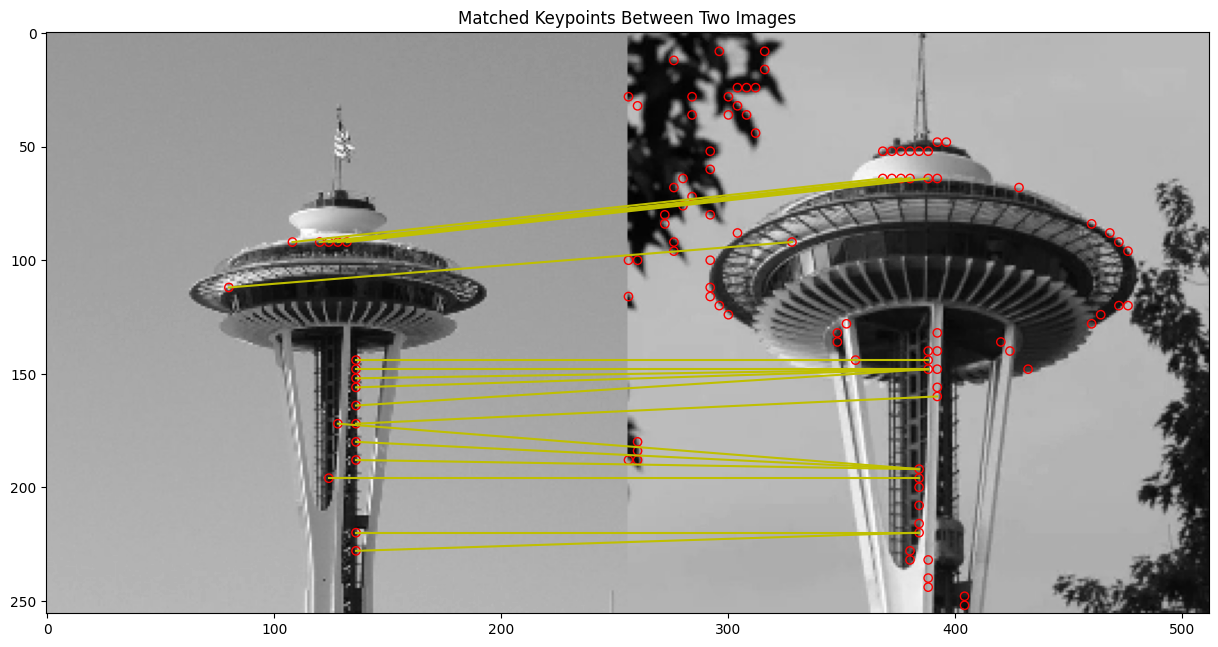

In [137]:
match_and_plot_hogs(hog1, image1, hog2, image3)